In [1]:
import numpy as np
from uncertainties import ufloat, unumpy
from uncertainties.umath import *
from astropy.io import fits
from astropy.table import Table
import pandas
import matplotlib.pyplot as plt
from astropy.stats import LombScargle
from scipy.ndimage.filters import gaussian_filter
from scipy import signal
from importlib import reload as reload
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pulsations as p

# Set Up File Path if Needed

In [3]:
#epoch1, epoch2, epoch3 folders should be within datadir
datadir = 'NIC_3ep'

# Load in Evt Files for Each Epoch 
- one variable for events, one for times
- comparisons to original times, etc. done in other notebook and pdf


In [4]:
#paths to each epoch
e1path = datadir+'/epoch1/'
e2path = datadir+'/epoch2/'
e3path = datadir+'/epoch3/'
#tables of start and end times from each epoch
tep1 = p.readevt(e1path+'epoch1-sun80-spaceweather_bar.evt',ind=2)
tep2 = p.readevt(e2path+'epoch2-sun80-spaceweather_bar.evt',ind=2)
tep3 = p.readevt(e3path+'epoch3-sun80-spaceweather_bar.evt',ind=2)
#corresponding event tables
ep1 = p.readevt(e1path+'epoch1-sun80-spaceweather_bar.evt')
ep2 = p.readevt(e2path+'epoch2-sun80-spaceweather_bar.evt')
ep3 = p.readevt(e3path+'epoch3-sun80-spaceweather_bar.evt')


In [5]:
def sf(filename):
    '''
    Saves figure in LXP_69_NICER/0.3-8.0Figs/3Epoch
    '''
    plt.savefig('LXP_69_NICER/0.3-8.0Figs/3Epoch/'+filename+'.png',dpi=200,bbox_inches='tight')

## Exposure Times

In [6]:
ep1time = np.sum(tep1['STOP']-tep1['START'])
ep2time = np.sum(tep2['STOP']-tep2['START'])
ep3time = np.sum(tep3['STOP']-tep3['START'])
print(ep1time,ep2time,ep3time)

6464.003115236759 527.9994794428349 3014.9777161478996


# Filter to 0.3-8.0 keV
- and save variables for soft (0.3-1.5) and hard (1.5-8.0) bands

In [7]:
#first epoch
ep1 = ep1[ep1['PI']>=30]
ep1 = ep1[ep1['PI']<=800]
soft_ep1 = ep1[ep1['PI']<=150]
hard_ep1 = ep1[ep1['PI']>150]

In [8]:
#epoch 3
ep3 = ep3[ep3['PI']>=30]
ep3 = ep3[ep3['PI']<=800]
soft_ep3 = ep3[ep3['PI']<=150]
hard_ep3 = ep3[ep3['PI']>150]

#epoch 2
ep2 = ep2[ep2['PI']>=30]
ep2 = ep2[ep2['PI']<=800]
soft_ep2 = ep2[ep2['PI']<=150]
hard_ep2 = ep2[ep2['PI']>150]

# Use Original Periods
- but importing HENDRICS results for epochs 1 and 3
- change period values here if need be

In [9]:
#period for first epoch; variable names from original naming
pd = 68.68201618721699
#period for third epoch
compd = 68.56842782790496

In [10]:
#from HENDRICS on new version of epoch1
#search between 0.01 and 0.02 Hz, oversample=10

#commenting out 
# import hendrics.io
# import hendrics.plot as hp
# ep1ez=hendrics.io.load_folding(e1path+'epoch1-sun80-spaceweather_bar_nicer_xti_Z2n_0.01-0.02Hz.p')

# plt.plot(ep1ez.freq, ep1ez.stat, drawstyle='steps-mid',color='navy')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Z2n stat')

In [11]:
# ep1p_res = pandas.DataFrame(columns=['freq','stat']) #zsearch result
# ep1p_res['freq'] = ep1ez.freq
# ep1p_res['stat'] = ep1ez.stat 
# ep1p_res = ep1p_res.sort_values(by='stat',ascending=False)

In [12]:
# ep1p_res['pd'] = 1/ep1p_res['freq']
# ep1p_res[:10]

#not shown as first three, but essentially same three top solutions

# Counts Pulse Profiles


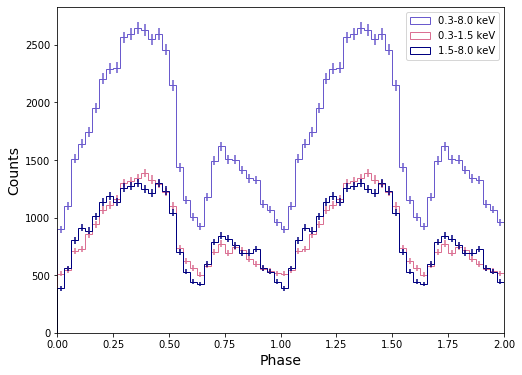

In [13]:
ep1hists,ep1mids = p.phasehist_sh([ep1,soft_ep1,hard_ep1],pd,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],bins=64,epoch=10)

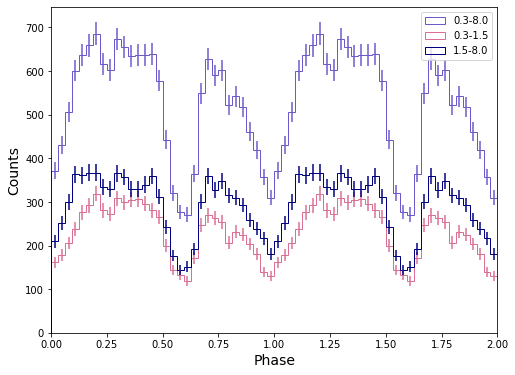

In [14]:
#epoch (phase) shifts approximate
ep3hists,ep3mids = p.phasehist_sh([ep3,soft_ep3,hard_ep3],compd,ens=['0.3-8.0','0.3-1.5','1.5-8.0'],bins=64,epoch=-14)


# BG-Subtracted Count Rate Pulse Profiles
- background subtraction based on percentages provided in xspec
- exposure time used to get count rate

In [15]:
#background percentages for epoch 1
ep1_ssub = .109*len(soft_ep1)/ep1time #avg rate * percentage that's BG
ep1_hsub = .082*len(hard_ep1)/ep1time
ep1_tsub = .095*len(ep1)/ep1time
print('soft:',ep1_ssub,'hard:',ep1_hsub,'total:',ep1_tsub)

soft: 0.46250782165511023 hard: 0.34814463419663333 total: 0.8064414430296988


In [16]:
#background percentages for epoch 3
ep3_ssub = .156*len(soft_ep3)/ep3time 
ep3_hsub = .098*len(hard_ep3)/ep3time
ep3_tsub = .123*len(ep3)/ep3time
print(ep3_ssub,ep3_hsub,ep3_tsub)

0.38325059379752885 0.30336343618770967 0.6829304206701456


In [17]:
#lists of bg: count rate to subtract from each total, soft, and hard bin, respectively
ep1bg=[ep1_tsub,ep1_ssub,ep1_hsub] #background argument,subtracting once y-axis is counts/s
ep3bg=[ep3_tsub,ep3_ssub,ep3_hsub]

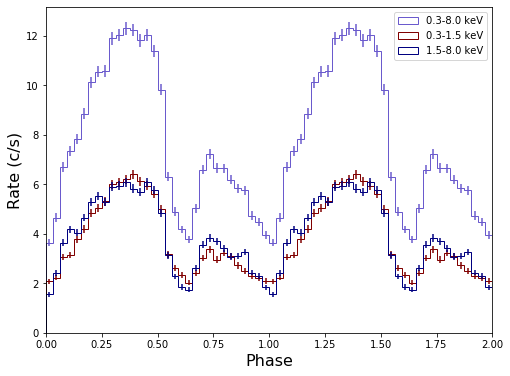

In [18]:
#convert epoch 1 to count rates, bg-subtraction
ep1rateh,ep1errs = p.phaserate(ep1hists,ep1mids,ep1time,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],
                             bgb=True,bg=ep1bg)

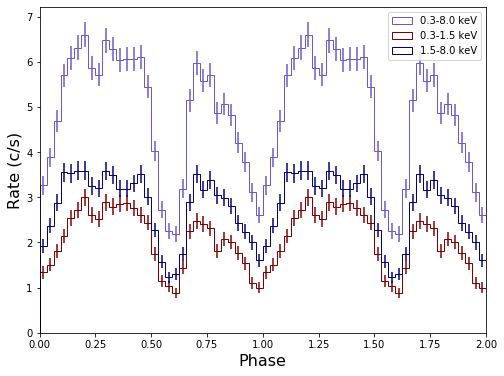

In [19]:
#repeat for epoch 3
ep3rateh,ep3errs = p.phaserate(ep3hists,ep3mids,ep3time,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],
                             bgb=True,bg=ep3bg)

# 2D Histograms
- then can make final three-panel figures
- approximated BG for each of 32 bins; maybe not best way
    - summed every 24 even though # channels not divisible by 32

Text(0, 0.5, 'Time (s)')

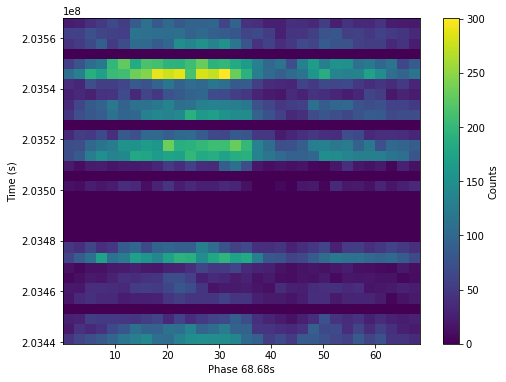

In [20]:
#first: time vs. phase hists
ep1ph = (ep1['TIME']+10)%pd
plt.figure(figsize=(8,6)) 
hist = plt.hist2d(ep1ph,ep1['TIME'],bins=32)
plt.colorbar(label='Counts')
plt.xlabel('Phase 68.68s')
plt.ylabel('Time (s)')

Text(0, 0.5, 'Time (s)')

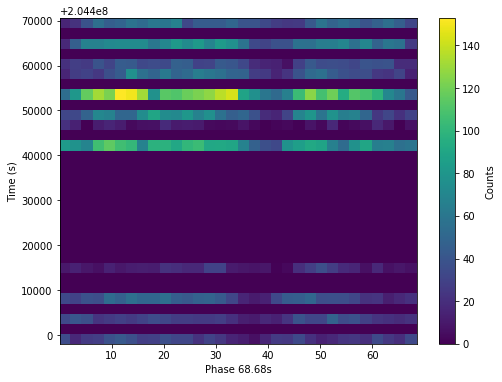

In [21]:
#repeat for epoch 3
#epoch used for pulse profile
ep3ph = (ep3['TIME']-14)%compd
plt.figure(figsize=(8,6)) 
hist = plt.hist2d(ep3ph,ep3['TIME'],bins=32)
plt.colorbar(label='Counts')
plt.xlabel('Phase 68.68s')
plt.ylabel('Time (s)')

Text(0.5, 0, 'Phase')

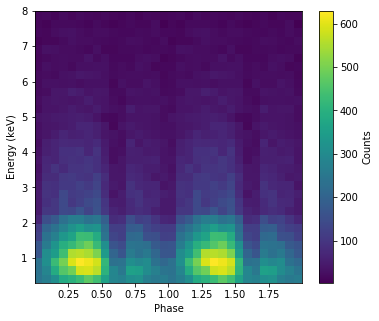

In [22]:
#energy-phase without normalization
#need background as function of energy for these bins
plt.figure(figsize=(6,5)) 
ep1ph1 = ep1ph/pd
ep1ph2 = ep1ph1 + 1
ep1ph3 = list(ep1ph1)+list(ep1ph2)
ep1ed2 = list(ep1['PI'])+list(ep1['PI'])
ep1enhist = plt.hist2d(ep1ph3,np.array(ep1ed2)/100,bins=32) #convert from PI to keV
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')

Text(0.5, 0, 'Phase')

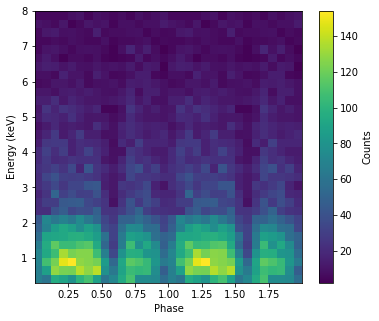

In [23]:
#repeating for epoch 3
#energy-phase without normalization
#need background as function of energy for these bins
plt.figure(figsize=(6,5)) 
ep3ph1 = ep3ph/compd
ep3ph2 = ep3ph1 + 1
ep3ph3 = list(ep3ph1)+list(ep3ph2)
ep3ed2 = list(ep3['PI'])+list(ep3['PI'])
ep3enhist = plt.hist2d(ep3ph3,np.array(ep3ed2)/100,bins=32) #convert from PI to keV
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')

- leaving approximate bg binning for now, for comparison
- ultimately use gv bg hists

In [83]:
#GV bg files
gvb1 = np.loadtxt(e1path+'BG_epoch1.ascii')
gvb3 = np.loadtxt(e3path+'BG_epoch3.ascii')

In [84]:
np.sum(gvb1[:,1])*ep1time

5211.002614032925

In [81]:
np.sum(ep1enbg)

5205.0

Text(0, 0.5, 'Background (counts)')

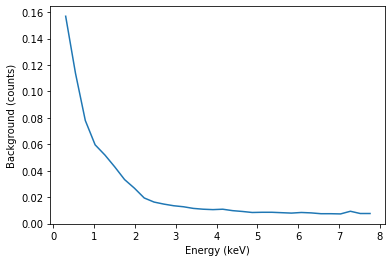

In [86]:
plt.plot(gvb1[:,0],gvb1[:,1])
plt.xlabel('Energy (keV)')
plt.ylabel('Background (counts)')#is this background counts/s so we scale up ?
# sf('ep1bg?')

In [67]:
#background for 32 bins epoch1
ep1back = p.readevt(e1path+'back_epoch1-sun80-spaceweather.pha',ind=1)
ep1back = ep1back[ep1back['CHANNEL']>=30]
ep1back = ep1back[ep1back['CHANNEL']<=800]
ep1bc = np.array(ep1back['COUNTS'])
ep1enbg = np.zeros(32)
for i in range(32):
    ep1enbg[i] = np.sum(ep1bc[24*i:24*(i+1)])

In [29]:
#background for 32 bins epoch3
ep3back = p.readevt(e3path+'back_epoch3-sun80-spaceweather.pha',ind=1)
ep3back = ep3back[ep3back['CHANNEL']>=30]
ep3back = ep3back[ep3back['CHANNEL']<=800]
ep3bc = np.array(ep3back['COUNTS'])
ep3enbg = np.zeros(32)
for i in range(32):
    ep3enbg[i] = np.sum(ep3bc[24*i:24*(i+1)])
    

In [30]:
#divide by exposure time to get average
ep1enbg = ep1enbg/ep1time
ep3enbg = ep3enbg/ep3time

In [38]:
#version with each row normalized; bg-subtracted
#convert to count rate -- make sure corresponding
ep1norm_bg = np.zeros((32,32)) #16 phase bins, 32 energy bins
for i in range(32):
    ep1norm_bg[i,:] = ((ep1enhist[0][:,31-i]*16/ep1time)-ep1enbg[31-i]) 
    ep1norm_bg[i,:] = ep1norm_bg[i,:]/np.median(ep1norm_bg[i,:]) #16 phase bins

In [88]:
#gv bg
#version with each row normalized; bg-subtracted
#convert to count rate -- make sure corresponding
gv1norm_bg = np.zeros((32,32)) #16 phase bins
for i in range(32):
    gv1norm_bg[i,:] = ((ep1enhist[0][:,31-i]*16/ep1time)-gvb1[31-i,1]) 
    gv1norm_bg[i,:] = gv1norm_bg[i,:]/np.median(gv1norm_bg[i,:]) 

In [40]:
#version with each row normalized; bg-subtracted
#convert to count rate -- make sure corresponding
ep3norm_bg = np.zeros((32,32)) 
for i in range(32):
    ep3norm_bg[i,:] = ((ep3enhist[0][:,31-i]*16/ep3time)-ep1enbg[31-i]) 
    ep3norm_bg[i,:] = ep3norm_bg[i,:]/np.median(ep3norm_bg[i,:]) #16 phase bins

In [89]:
#gv bg epoch 3
#version with each row normalized; bg-subtracted
#convert to count rate -- make sure corresponding
gv3norm_bg = np.zeros((32,32)) #16 phase bins
for i in range(32):
    gv3norm_bg[i,:] = ((ep3enhist[0][:,31-i]*16/ep3time)-gvb3[31-i,1]) 
    gv3norm_bg[i,:] = gv3norm_bg[i,:]/np.median(gv3norm_bg[i,:]) 

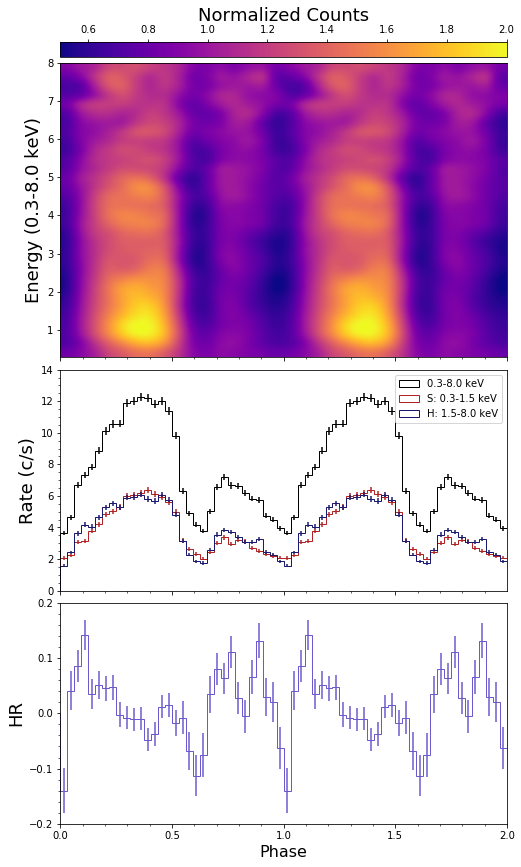

In [29]:
#heat map as middle panel with pulse profile and hardness ratios
#bg-subtracted
reload(p)
#32 phase bins (16 in "final" notebook)
ep1_3pan,ep1_3panerr = p.phaserate(ep1hists,ep1mids,ep1time,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],rate=True,figsize=(8,14),bgb=True,bg=ep1bg,enhist=True,ed=ep1,pd=pd,norm_bg=ep1norm_bg,yrange2=[-0.2,0.18])
# sf('panelep1')

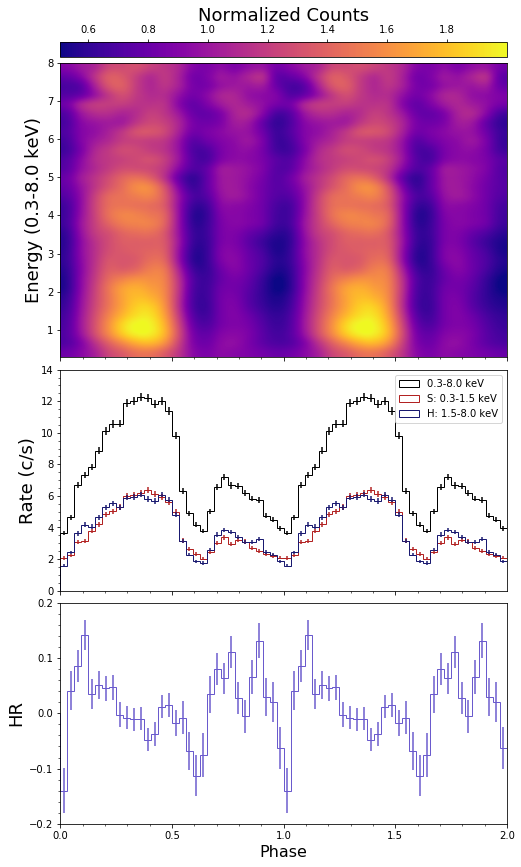

In [92]:
#heat map as middle panel with pulse profile and hardness ratios
#bg-subtracted
reload(p)
#32 phase bins (16 in "final" notebook)
ep1_3pan,ep1_3panerr = p.phaserate(ep1hists,ep1mids,ep1time,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],rate=True,figsize=(8,14),bgb=True,bg=ep1bg,enhist=True,ed=ep1,pd=pd,norm_bg=gv1norm_bg,yrange2=[-0.2,0.18])
sf('panelep1')

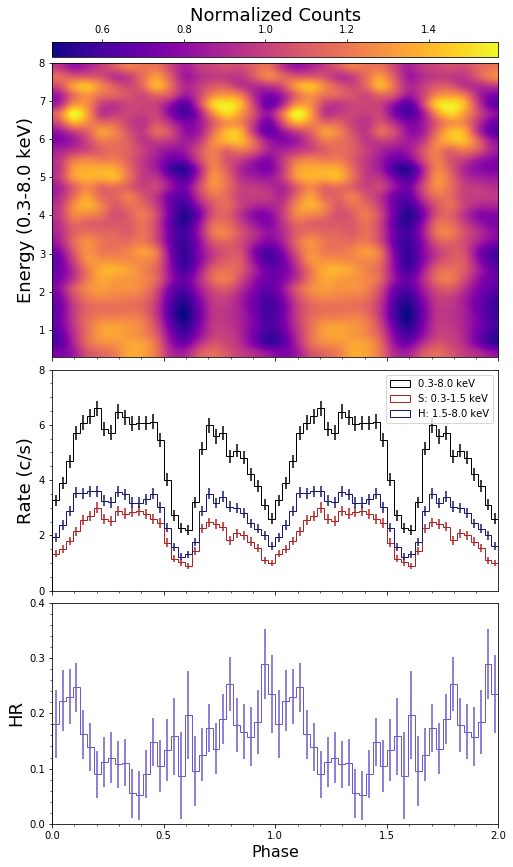

In [30]:
#for epoch 3; bg-subtracted
ep3_3pan,ep3_3panerr = p.phaserate(ep3hists,ep3mids,ep3time,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],
                               rate=True,figsize=(8,14),bgb=True,bg=ep3bg,enhist=True,ed=ep3,pd=compd,norm_bg=ep3norm_bg,yrange1=[0,7],yrange2=[0,0.4])
# sf('panelep3')

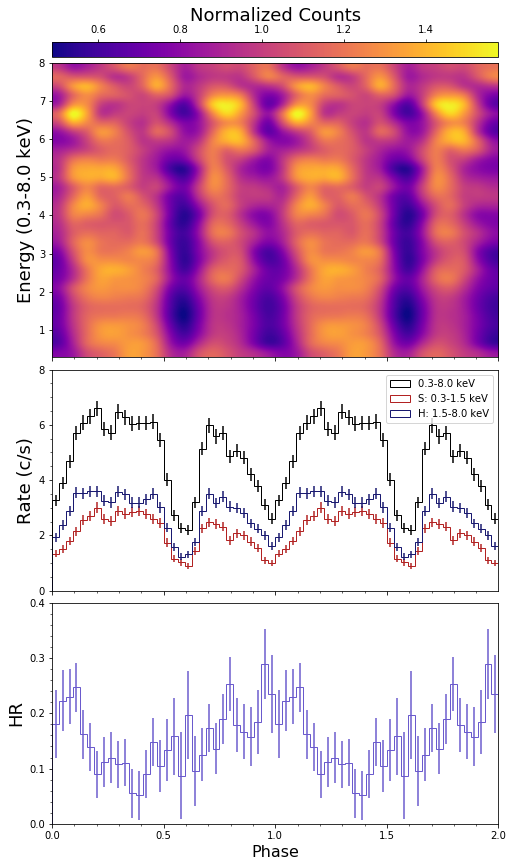

In [93]:
#for epoch 3; bg-subtracted
ep3_3pan,ep3_3panerr = p.phaserate(ep3hists,ep3mids,ep3time,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],
                               rate=True,figsize=(8,14),bgb=True,bg=ep3bg,enhist=True,ed=ep3,pd=compd,norm_bg=gv3norm_bg,yrange1=[0,7],yrange2=[0,0.4])
sf('panelep3')

Text(0, 0.5, 'bg counts?')

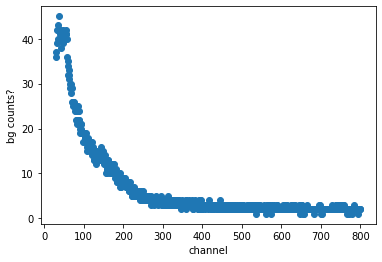

In [31]:
plt.scatter(ep1back['CHANNEL'],ep1back['COUNTS'])
plt.xlabel('channel')
plt.ylabel('bg counts?')

# PF as Function of Energy
- next update will be to move this code to module but this is fine for now

In [32]:
#make tables for energies: ep1
ep1_en1 = ep1[ep1['PI']<=70]
ep1_en2 = ep1[ep1['PI']>70]
ep1_en2 = ep1_en2[ep1_en2['PI']<=100]
ep1_en3 = ep1[ep1['PI']>100]
ep1_en3 = ep1_en3[ep1_en3['PI']<=150]
ep1_en4 = ep1[ep1['PI']>150]
ep1_en4 = ep1_en4[ep1_en4['PI']<=200]
ep1_en5 = ep1[ep1['PI']>200]
ep1_en5 = ep1_en5[ep1_en5['PI']<=300]
ep1_en6 = ep1[ep1['PI']>300]
ep1_en6 = ep1_en6[ep1_en6['PI']<=500]
ep1_en7 = ep1[ep1['PI']>500]
ep1_en7 = ep1_en7[ep1_en7['PI']<=800]

In [33]:
#how much to subtract from each bin
ep1_bg1 = .167*len(ep1_en1)/ep1time #avg rate * percentage that's BG
ep1_bg2 = .087*len(ep1_en2)/ep1time
ep1_bg3 = .208*len(ep1_en3)/ep1time
ep1_bg4 = .067*len(ep1_en4)/ep1time
ep1_bg5 = .16*len(ep1_en5)/ep1time
ep1_bg6 = .147*len(ep1_en6)/ep1time
ep1_bg7 = .145*len(ep1_en7)/ep1time

ep1_pfbg = [ep1_bg1,ep1_bg2,ep1_bg3,ep1_bg4,ep1_bg5,ep1_bg6,ep1_bg7]

In [34]:
#make tables for energies: ep3
ep3_en1 = ep3[ep3['PI']<=70]
ep3_en2 = ep3[ep3['PI']>70]
ep3_en2 = ep3_en2[ep3_en2['PI']<=100]
ep3_en3 = ep3[ep3['PI']>100]
ep3_en3 = ep3_en3[ep3_en3['PI']<=150]
ep3_en4 = ep3[ep3['PI']>150]
ep3_en4 = ep3_en4[ep3_en4['PI']<=200]
ep3_en5 = ep3[ep3['PI']>200]
ep3_en5 = ep3_en5[ep3_en5['PI']<=300]
ep3_en6 = ep3[ep3['PI']>300]
ep3_en6 = ep3_en6[ep3_en6['PI']<=500]
ep3_en7 = ep3[ep3['PI']>500]
ep3_en7 = ep3_en7[ep3_en7['PI']<=800]

In [35]:
#epoch 3 bg values
ep3_bg1 = .26*len(ep3_en1)/ep3time #avg rate * percentage that's BG
ep3_bg2 = .125*len(ep3_en2)/ep3time
ep3_bg3 = .314*len(ep3_en3)/ep3time
ep3_bg4 = .087*len(ep3_en4)/ep3time
ep3_bg5 = .228*len(ep3_en5)/ep3time
ep3_bg6 = .201*len(ep3_en6)/ep3time
ep3_bg7 = .195*len(ep3_en7)/ep3time

ep3_pfbg = [ep3_bg1,ep3_bg2,ep3_bg3,ep3_bg4,ep3_bg5,ep3_bg6,ep3_bg7]

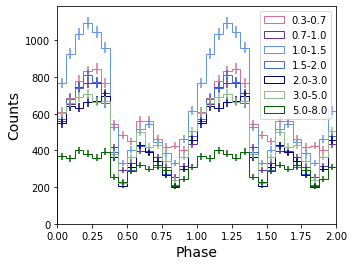

In [36]:
ep1pfens,ep1pfmids = p.phasehist_sh([ep1_en1,ep1_en2,ep1_en3,ep1_en4,ep1_en5,ep1_en6,ep1_en7],pd,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],figsize=(5,4))

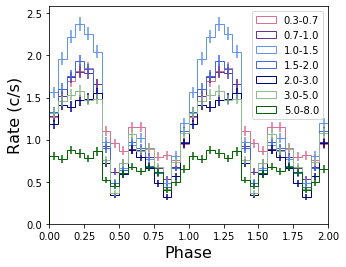

In [37]:
#epoch 1 bg-subtracted count rate hist
reload(p)
ep1pfcr,ep1pfcrerr = p.phaserate(ep1pfens,ep1pfmids,ep1time,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(5,4),bgb=True,bg=ep1_pfbg)


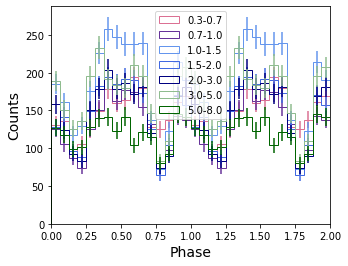

In [38]:
ep3pfens,ep3pfmids = p.phasehist_sh([ep3_en1,ep3_en2,ep3_en3,ep3_en4,ep3_en5,ep3_en6,ep3_en7],compd,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],figsize=(5,4))


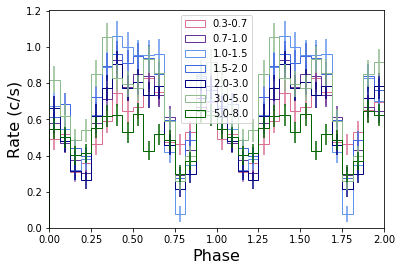

In [39]:
ep3pfcr,ep3pfcrerr = p.phaserate(ep3pfens,ep3pfmids,ep3time,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=True,bg=ep3_pfbg)

In [40]:
#calculate epoch1 pulsed fractions
ep1pf = []
ep1pfn = []
ep1pfe = []
for i in range(7):
    cr = ep1pfens[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)]
    rerr = unumpy.uarray(r,np.sqrt(r))
    rmax = rerr.max()
    rmin = rerr.min()
    ep1pf.append((rmax-rmin)/(rmax+rmin))
    ep1pfn.append(((rmax-rmin)/(rmax+rmin)).n)
    ep1pfe.append(((rmax-rmin)/(rmax+rmin)).s)
ep1pfn

[0.352,
 0.5024390243902439,
 0.5360896986685354,
 0.5901960784313726,
 0.5506117908787542,
 0.524731182795699,
 0.3212520593080725]

In [41]:
#with bg-subtraction
ep1pfr = [] #adding r to variables (for rate)
ep1pfnr = []
ep1pfer = []
for i in range(7):
    cr = ep1pfcr[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)] #first half of count rates, since second half just repeated
    e = ep1pfcrerr[i][:int(totlen/2)] #errors originally from sqrt of counts
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    ep1pfr.append((rmax-rmin)/(rmax+rmin))
    ep1pfnr.append(((rmax-rmin)/(rmax+rmin)).n) #value
    ep1pfer.append(((rmax-rmin)/(rmax+rmin)).s) #propogated error
ep1pfnr

[0.4168280592544776,
 0.5472702703528417,
 0.6613322083481736,
 0.6291130420515567,
 0.6541734947401807,
 0.6199559107174563,
 0.37789782224267865]

In [42]:
#epoch 3
ep3pf = []
ep3pfn = []
ep3pfe = []
for i in range(7):
    cr = ep3pfens[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)]
    rerr = unumpy.uarray(r,np.sqrt(r))
    rmax = rerr.max()
    rmin = rerr.min()
    ep3pf.append((rmax-rmin)/(rmax+rmin))
    ep3pfn.append(((rmax-rmin)/(rmax+rmin)).n)
    ep3pfe.append(((rmax-rmin)/(rmax+rmin)).s)
ep3pfn

[0.33793103448275863,
 0.45454545454545453,
 0.5636363636363636,
 0.4980694980694981,
 0.4676258992805755,
 0.47468354430379744,
 0.28888888888888886]

In [43]:
#epoch 3 with bg-subtraction
ep3pfr = [] #adding r to variables (for rate)
ep3pfnr = []
ep3pfer = []
for i in range(7):
    cr = ep3pfcr[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)] #first half of count rates, since second half just repeated
    e = ep3pfcrerr[i][:int(totlen/2)] #errors originally from sqrt of counts
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    ep3pfr.append((rmax-rmin)/(rmax+rmin))
    ep3pfnr.append(((rmax-rmin)/(rmax+rmin)).n) #value
    ep3pfer.append(((rmax-rmin)/(rmax+rmin)).s) #propogated error
ep3pfnr


[0.4581205371229565,
 0.5195508050331482,
 0.8686149794054198,
 0.552364059297781,
 0.6154589074657529,
 0.6063457110388778,
 0.36465893870223437]

Text(0, 0.5, 'PF')

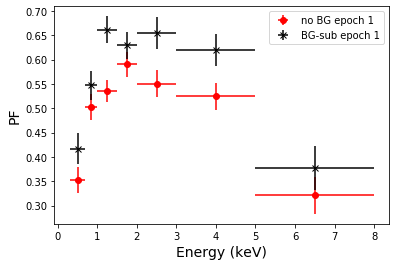

In [44]:
#epoch 1
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],ep1pfn,yerr=ep1pfe,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',linestyle='none',color='red',label='no BG epoch 1')
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],ep1pfnr,yerr=ep1pfer,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='x',linestyle='none',color='black',label='BG-sub epoch 1')


plt.legend()
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('PF',fontsize=14)
#sf('PFep1')

Text(0, 0.5, 'PF')

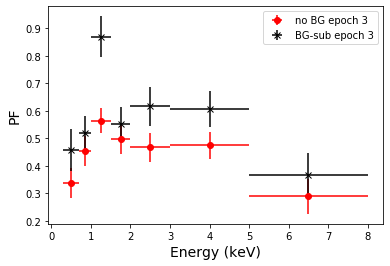

In [45]:
#epoch 3: high third band value b/c of high percentage of BG
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],ep3pfn,yerr=ep3pfe,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',linestyle='none',color='red',label='no BG epoch 3')
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],ep3pfnr,yerr=ep3pfer,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='x',linestyle='none',color='black',label='BG-sub epoch 3')

plt.legend()
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('PF',fontsize=14)
# sf('PFep3')

# Useful Values

In [46]:
print('periods used for epochs 1 and 3:',pd,compd)

periods used for epochs 1 and 3: 68.68201618721699 68.56842782790496


In [47]:
print('exposure times for all three epochs:', ep1time,ep2time,ep3time)

exposure times for all three epochs: 6464.003115236759 527.9994794428349 3014.9777161478996


In [48]:
def pf2(countrate,err):
    totlen = len(countrate)
    r=countrate[:int(totlen/2)]
    err=err[:int(totlen/2)]
    rerr=unumpy.uarray(r,err)
    rmax = rerr.max()
    rmin = rerr.min()
    pf = (rmax-rmin)/(rmax+rmin)#count rate in phase bins up to 1
    return pf

In [49]:
pf2(ep1rateh[0][0],ep1errs[0])


0.5430191960549515+/-0.016122481934121916

In [50]:
pf2(ep3rateh[0][0],ep3errs[0])

0.5010193933741686+/-0.03374719746341396

In [51]:
#32 phase bins epoch 1
import scipy.stats as st
print('min total rate: ',np.min(ep1rateh[0][0]),np.min(ep1errs[0]))
print('max total rate: ',np.max(ep1rateh[0][0]),np.max(ep1errs[0]))
print('mean total rate: ',np.mean(ep1rateh[0][0]))
print('total standard error', st.sem(ep1rateh[0][0]))

min total rate:  3.6391009689571305 0.14834967171055663
max total rate:  12.287611652410362 0.2546016767164825
mean total rate:  7.682415852019761
total standard error 0.3680121895339414


In [52]:
#32 phase bins epoch 3
print('min total rate: ',np.min(ep3rateh[0][0]),np.min(ep3errs[0]))
print('max total rate: ',np.max(ep3rateh[0][0]),np.max(ep3errs[0]))
print('mean total rate: ',np.mean(ep3rateh[0][0]))
print('total standard error', st.sem(ep3rateh[0][0]))

min total rate:  2.193376078563233 0.1747231767052626
max total rate:  6.598052082924312 0.27798920375046926
mean total rate:  4.869349422176566
total standard error 0.16920628117164915


# Comparison to 2000 Pulse Profile

In [53]:
pwd

'/Users/lenatreiber/Desktop/Yale'

In [56]:
pde = pandas.read_csv('LXP_69_NICER/2000werrors.csv',names=['Phase','Int']) #normalized intensity
papdata = pandas.read_csv('LXP_69_NICER/2003PP.csv',names=['Phase','Int']) 

In [57]:
ppd = 69.232
paper = ep1[ep1['PI']<=750] 

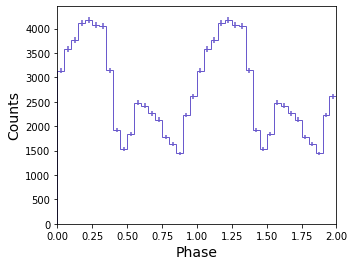

In [59]:
#bins to match paper
paphist3,pmids3 = p.phasehist(paper,pd,bins=40,figsize=(5,4))

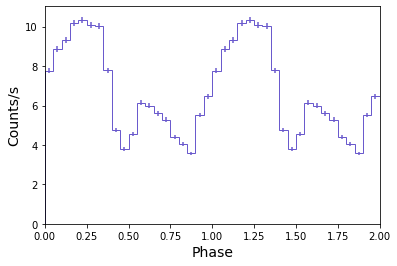

In [61]:
p3,p3err = p.s_phaserate(paphist3,pmids3,ep1time) 

In [55]:
p_err = []
for j in np.arange(0,40):
    p_err.append(pde['Int'][40+2*j])

In [63]:
np.mean(p3[0])/papdata['Int'].mean()

6.721678431288408

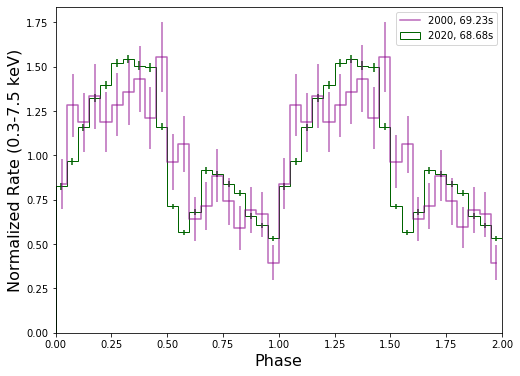

In [69]:
mod = p.phaseroll(p3[1],p3[0]/6.7,2,np.array(pmids3),p3err/6.7,label='2020, 68.68s',color='darkgreen')
#plt.savefig(path+'shiftedpp.png',dpi=200,bbox_inches='tight')
paproll = np.roll(papdata['Int'],-1)
perroll = np.roll(p_err,-1)
#paproll=papdata['Int']
#perroll=p_err

plt.step(papdata['Phase']+.025,paproll,where='mid',color='darkmagenta',alpha=.6,label='2000, 69.23s')
plt.errorbar(papdata['Phase']+.025,paproll,yerr=np.abs(perroll-paproll),alpha=.6,linestyle='none',color='darkmagenta')
plt.legend()
#plt.ylabel('Counts/s (0.3-7.5 keV)')

plt.ylabel('Normalized Rate (0.3-7.5 keV)',fontsize=16)
sf('newpap')